In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from cinnabar.plotting import _master_plot
from cinnabar import stats
import seaborn as sns
import numpy as np

sns.set_context("talk")

In [2]:
# load the basic edge data
cumulative_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_cumulative_data.csv")
# load our edge data with exp values
normal_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_edge_data.csv")

In [3]:
# load the private edge and cumulative data
private_cumulative_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_cumulative_data.csv")
private_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_edge_data.csv")
private_edge_data = private_edge_data[private_edge_data["failed"] != True]
private_edge_data

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_dDG (kcal/mol),complex_repeat_1_com_drift_max,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed
0,unknown_ligand_6,unknown_ligand_9,1.000000,0,1.0,1.000000,1.000000,0.999901,21,0,...,2.231493e-10,1.496107,2.483988,0.090909,0.000000,2.839362e-10,1.771044,2.238705,0.090909,NaN
1,unknown_ligand_3,unknown_ligand_15,0.904837,0,1.0,0.046432,1.000000,0.761981,20,1,...,2.455996e-02,1.615484,2.155722,0.103056,-0.601893,2.564494e-02,1.976220,3.056871,0.103643,NaN
2,unknown_ligand_15,unknown_ligand_21,0.904837,0,1.0,0.046591,1.000000,0.762179,20,0,...,3.643987e-02,2.341021,3.475891,0.110198,1.370174,3.546106e-02,2.180326,3.084103,0.106760,NaN
3,unknown_ligand_15,unknown_ligand_5,0.904837,0,1.0,0.047457,1.000000,0.757272,20,0,...,2.883455e-02,1.911599,2.986635,0.119243,-0.866684,3.144320e-02,1.628999,2.337637,0.117861,NaN
4,unknown_ligand_21,unknown_ligand_5,0.818731,0,1.0,0.091968,1.000000,0.677922,20,1,...,4.467752e-02,1.444678,3.283127,0.121850,-1.953068,5.534813e-02,1.782087,3.081785,0.126268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,ligand11,ligand12,0.020242,0,1.0,0.205950,0.405952,0.895260,26,16,...,4.390646e-01,125.984756,126.013779,0.008125,-152.669851,6.001595e-01,111.879089,111.980225,0.002787,NaN
1428,ligand0,ligand11,0.030197,0,1.0,0.193953,0.406137,0.942570,26,9,...,4.335208e-01,118.773781,118.922112,0.012684,114.461670,2.665547e-01,120.105179,120.169167,0.012729,NaN
1429,ligand8,ligand3,0.212248,0,1.0,0.165417,0.645056,0.793032,28,7,...,3.166176e-01,122.461555,122.546555,0.017953,-21.543263,2.768983e-01,115.884491,115.910095,0.016368,NaN
1430,ligand2,ligand3,0.272532,0,1.0,0.157825,0.671910,0.831267,28,5,...,2.358288e-01,121.872475,122.149765,0.028739,100.395024,1.945049e-01,122.015831,122.021210,0.025002,NaN


In [4]:
# load the dg data
public_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv")
private_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_calculated_dg_data.csv")

In [5]:
# the cumulative data has each phase and repeat on a new line
# create a new csv with the DDG prediction for the edge after each ns + the error
per_ns_ddgs_neutral, per_ns_ddgs_charged = [], []
for _, row in normal_edge_data.iterrows():
    # skip the intermediates as we need to calculate the error for the edges
    if pd.isna(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "system group": row["system group"],
        "system name": row["system name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each ns
    temp_cumulative_data = cumulative_data[(cumulative_data["system group"] == row["system group"]) & (cumulative_data["system name"] == row["system name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]

    for i in range(1, total_ns + 1):
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {i} ns DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {i} ns dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    # workout where to store the row
    if total_ns == 5:
        per_ns_ddgs_neutral.append(cumulative_data_row)
    else:
        per_ns_ddgs_charged.append(cumulative_data_row)
    
per_ns_ddgs_neutral = pd.DataFrame(per_ns_ddgs_neutral)
per_ns_ddgs_charged = pd.DataFrame(per_ns_ddgs_charged)

In [6]:
# same again for the private data
per_ns_ddgs_neutral_private, per_ns_ddgs_charged_private = [], []
for _, row in private_edge_data.iterrows():
    # skip the intermediates as we need to calculate the error for the edges
    if pd.isna(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "partner": row["partner_id"],
        "system name": row["dataset_name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each ns
    temp_cumulative_data = private_cumulative_data[(private_cumulative_data["partner_id"] == row["partner_id"]) & (private_cumulative_data["dataset_name"] == row["dataset_name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]

    for i in range(1, total_ns + 1):
        # print(complex_data[f"Samples {i}ns (subsample) DG"])
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {i} ns DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {i} ns dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    # workout where to store the row
    if total_ns == 5:
        per_ns_ddgs_neutral_private.append(cumulative_data_row)
    else:
        per_ns_ddgs_charged_private.append(cumulative_data_row)
per_ns_ddgs_neutral_private = pd.DataFrame(per_ns_ddgs_neutral_private)
per_ns_ddgs_charged_private = pd.DataFrame(per_ns_ddgs_charged_private)

In [7]:
per_ns_ddgs_neutral_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 1 ns DDG,Samples 1 ns dDDG,Samples 2 ns DDG,Samples 2 ns dDDG,Samples 3 ns DDG,Samples 3 ns dDDG,Samples 4 ns DDG,Samples 4 ns dDDG,Samples 5 ns DDG,Samples 5 ns dDDG
0,ASAP,Enterovirus,unknown_ligand_3,unknown_ligand_15,1.148118,0.055056,0,1.104402,0.136664,1.065402,0.113571,1.032865,0.083231,1.014247,0.088905,0.972771,0.080710
1,ASAP,Enterovirus,unknown_ligand_15,unknown_ligand_21,0.327255,0.076637,0,0.245326,0.278446,0.195591,0.249188,0.272850,0.135000,0.287770,0.054534,0.272273,0.138030
2,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_7,0.286348,0.032221,0,0.358455,0.296355,0.201361,0.166809,0.184357,0.209376,0.190192,0.125339,0.233306,0.140381
3,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_16,0.818136,0.048821,0,1.374171,0.281929,1.511584,0.360573,1.582223,0.327791,1.612850,0.166287,1.551585,0.149926
4,ASAP,Enterovirus,unknown_ligand_12,unknown_ligand_18,0.081814,0.094843,0,0.719973,0.259692,0.514005,0.145581,0.554642,0.141535,0.676114,0.143471,0.640925,0.105705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,Roche,target_D,ligand11,ligand12,2.561862,0.000000,0,2.183941,0.643764,2.646980,1.818435,2.770566,1.919833,2.565152,1.541890,2.049708,2.341527
1345,Roche,target_D,ligand0,ligand11,0.302856,0.000000,0,-2.440365,2.131070,-2.894143,1.298871,-2.691206,1.873933,-2.788925,1.604416,-1.950022,0.976101
1346,Roche,target_D,ligand8,ligand3,0.848769,0.000000,0,4.751131,3.875424,4.503254,3.178729,5.037318,2.624681,5.701962,2.505028,5.412539,3.130187
1347,Roche,target_D,ligand2,ligand3,1.876150,0.000000,0,2.367006,0.806749,2.181063,1.901754,2.414469,1.931305,3.915554,1.627744,4.712334,0.231165


In [8]:
# For some reason the estimate at 5ns is different for edge 27-6 in shp2 but all others are the same
# so we patch the value
# calculate the value for the 5 ns DDG
shp2_edge = normal_edge_data.loc[
    (normal_edge_data["system group"] == "merck") & 
    (normal_edge_data["system name"] == "shp2") & 
    (normal_edge_data["ligand_A"] == "Example-27") & 
    (normal_edge_data["ligand_B"] == "6")
]
complex_data = shp2_edge[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_data = shp2_edge[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
# calculate the 5 ns DDG and dDDG
ddg_5_ns = complex_data.mean(axis=1) - solvent_data.mean(axis=1)
ddg_5_ns_error = (complex_data.std(axis=1) ** 2 + solvent_data.std(axis=1) ** 2) ** 0.5
per_ns_ddgs_neutral.loc[
    (per_ns_ddgs_neutral["system group"] == "merck") & 
    (per_ns_ddgs_neutral["system name"] == "shp2") & 
    (per_ns_ddgs_neutral["ligand_A"] == "Example-27") & 
    (per_ns_ddgs_neutral["ligand_B"] == "6"), 
    "Samples 5 ns DDG"
] = ddg_5_ns.values[0]
per_ns_ddgs_neutral.loc[
    (per_ns_ddgs_neutral["system group"] == "merck") & 
    (per_ns_ddgs_neutral["system name"] == "shp2") & 
    (per_ns_ddgs_neutral["ligand_A"] == "Example-27") & 
    (per_ns_ddgs_neutral["ligand_B"] == "6"), 
    "Samples 5 ns dDDG"
] = ddg_5_ns_error.values[0]
# print the updated row 
print(per_ns_ddgs_neutral.loc[
    (per_ns_ddgs_neutral["system group"] == "merck") & 
    (per_ns_ddgs_neutral["system name"] == "shp2") & 
    (per_ns_ddgs_neutral["ligand_A"] == "Example-27") & 
    (per_ns_ddgs_neutral["ligand_B"] == "6")
])

    system group system name    ligand_A ligand_B  exp DDG (kcal/mol)  \
800        merck        shp2  Example-27        6            0.488493   

     exp dDDG (kcal/mol)  alchemical_charge_difference  Samples 1 ns DDG  \
800                  0.0                             0          -1.48332   

     Samples 1 ns dDDG  Samples 2 ns DDG  Samples 2 ns dDDG  Samples 3 ns DDG  \
800           3.879956         -0.127261            3.12252           1.21807   

     Samples 3 ns dDDG  Samples 4 ns DDG  Samples 4 ns dDDG  Samples 5 ns DDG  \
800           0.883363          0.349636           2.298812          0.716903   

     Samples 5 ns dDDG  
800            1.99501  


In [9]:
private_dg_data.rename(columns={
    "dataset_name": "system name",
    "partner_id": "partner"
}, inplace=True)

In [10]:
per_ns_ddgs_charged_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 1 ns DDG,Samples 1 ns dDDG,Samples 2 ns DDG,...,Samples 16 ns DDG,Samples 16 ns dDDG,Samples 17 ns DDG,Samples 17 ns dDDG,Samples 18 ns DDG,Samples 18 ns dDDG,Samples 19 ns DDG,Samples 19 ns dDDG,Samples 20 ns DDG,Samples 20 ns dDDG
0,EliLilly,Project0,ligand1,ligand7,1.777455,0.000000,1,-4.371133,0.480689,-4.898369,...,-4.796076,0.122531,-4.644950,0.114781,-4.524065,0.185205,-4.673515,0.222921,-4.504688,0.242691
1,EliLilly,Project0,ligand4,ligand0,-0.789979,0.000000,-1,-0.775481,0.371799,-0.721463,...,-1.312208,0.224725,-1.141644,0.102291,-1.164522,0.248846,-1.263990,0.234086,-1.225947,0.299367
2,EliLilly,Project0,ligand4,ligand1,-0.789979,0.000000,-1,3.950179,0.241692,3.633211,...,4.182846,0.092965,4.235930,0.163472,4.044490,0.084912,4.028628,0.269920,4.105049,0.329749
3,Janssen,systemA_set1,ligand37,ligand16,-1.203130,0.000000,1,-1.645602,0.752658,-1.740527,...,-0.710832,0.447642,-0.721140,0.468734,-0.597841,0.377830,-0.577474,0.318932,-0.613647,0.459593
4,Janssen,systemA_set1,ligand16,ligand7,3.987353,0.000000,-1,2.120420,0.379596,2.221253,...,1.981162,0.463214,2.017786,0.412967,2.044621,0.468847,2.133585,0.413000,2.146886,0.232271
5,Janssen,systemB_set1,ligand3,ligand14,-1.093211,0.000000,-1,-0.068371,1.181429,0.156495,...,0.175128,0.165142,0.317595,0.096497,0.165954,0.055430,0.152326,0.097757,0.117225,0.051230
6,Janssen,systemD_set1,ligand44,ligand24,-1.291761,0.000000,1,-6.576280,0.534685,-6.155122,...,-4.623347,1.056690,-4.613833,1.030578,-4.419519,1.028871,-4.440685,0.792133,-4.571122,0.810182
7,Janssen,systemD_set1,ligand20,ligand24,2.596778,0.000000,1,-0.840119,0.918987,-1.680294,...,-2.255919,0.463169,-2.392205,0.658250,-2.269477,0.593343,-2.369387,0.785890,-2.262589,1.071587
8,Merck,merck_private_T,ligand13,ligand7,-1.551022,0.000000,1,-1.564484,1.379854,-1.229770,...,-1.335891,0.340013,-1.327870,0.386084,-1.353970,0.433611,-1.354635,0.402888,-1.238370,0.482983
9,Merck,merck_private_T,ligand13,ligand27,-0.929890,0.000000,1,0.457163,0.688651,0.411509,...,0.863813,0.457157,0.857877,0.437650,0.937801,0.474259,0.894425,0.406869,0.920446,0.438434


In [45]:
from matplotlib.lines import Line2D
openfe_public_colour = "#8A2283"
openfe_private_colour = "#009384"
def plot_edgewise_stats_per_ns(public_neutral_df, public_charged_df, private_neutral_df, private_charged_df, filename):
    # make a subplot with 1 column and 2 rows 
    fig, axes = plt.subplots(2, 1, figsize=(8, 12))
    inset = axes[0].inset_axes([0.3, 0.2, 0.47, 0.47])

    nboot = 1000
    ci = 0.95

    colors = sns.color_palette("rocket", 5)

    # we want to use a combined simulation time axis of 20% increments 
    # rename the columns in the neutral df from 0ns to 20% etc
    def rename_column(name, total):
        ns = int(name.split(" ")[1])
        metric = name.split(" ")[-1]
        percent = int((ns / total) * 100)
        return f"Samples {percent}% {metric}"

    public_neutral_df = public_neutral_df.rename(columns={col: rename_column(col, 5) for col in public_neutral_df.columns if "Samples" in col})
    public_charged_df = public_charged_df.rename(columns={col: rename_column(col, 20) for col in public_charged_df.columns if "Samples" in col})
    private_neutral_df = private_neutral_df.rename(columns={col: rename_column(col, 5) for col in private_neutral_df.columns if "Samples" in col})
    private_charged_df = private_charged_df.rename(columns={col: rename_column(col, 20) for col in private_charged_df.columns if "Samples" in col})
    rmse_public_data = {}
    rmse_private_data = {}
    for i in range(20, 120, 20):
        # get the public neutral and charges data for this sample
        neutral_public = public_neutral_df[f"Samples {i}% DDG"].values
        exp_neutral_public = public_neutral_df["exp DDG (kcal/mol)"].values
        charged_public = public_charged_df[f"Samples {i}% DDG"].values
        exp_charged_public = public_charged_df["exp DDG (kcal/mol)"].values

        # stack the neutral and charged data
        combined_public = np.concatenate((neutral_public, charged_public))
        combined_exp_public = np.concatenate((exp_neutral_public, exp_charged_public))
        # calculate the absolute errors
        abs_errors_public = np.abs(combined_public - combined_exp_public)
        # plot the ecdf in first axis
        sns.ecdfplot(abs_errors_public, ax=axes[0], label=f"{i}%", color=colors[(i//20) -1], linestyle='-', linewidth=2)

        # plot the ecdf as an inset for the x range 1-5 kcal/mol
        sns.ecdfplot(abs_errors_public, ax=inset, label=f"{i}%", color=colors[(i//20) -1], linestyle='-', linewidth=2)
        

        # print the percentage of absolute errors less than 1 kcal/mol
        for x in range(1, 4):
            pct_less_than_x = np.sum(abs_errors_public < x) / len(abs_errors_public) * 100
            print(f"Public {i}%: {pct_less_than_x:.2f}% of absolute errors less than {x} kcal/mol")

        # do the same for the private data

        neutral_private = private_neutral_df[f"Samples {i}% DDG"].values
        exp_neutral_private = private_neutral_df["exp DDG (kcal/mol)"].values
        charged_private = private_charged_df[f"Samples {i}% DDG"].values
        exp_charged_private = private_charged_df["exp DDG (kcal/mol)"].values

        combined_private = np.concatenate((neutral_private, charged_private))
        combined_exp_private = np.concatenate((exp_neutral_private, exp_charged_private))
        abs_errors_private = np.abs(combined_private - combined_exp_private)
        sns.ecdfplot(abs_errors_private, ax=axes[0], label=f"{i}%", color=colors[(i//20) -1], linestyle='--', linewidth=2)
        # plot the ecdf as an inset for the x range 1-5 kcal/mol
        sns.ecdfplot(abs_errors_private, ax=inset, label=f"{i}%", color=colors[(i//20) -1], linestyle='--', linewidth=2)
        for x in range(1, 4):
            pct_less_than_x = np.sum(abs_errors_private < x) / len(abs_errors_private) * 100
            print(f"Private {i}%: {pct_less_than_x:.2f}% of absolute errors less than {x} kcal/mol")

        # calculate the RMSE with 95% confidence intervals using bootstrapping
        rmse_public, rmse_private = np.zeros(nboot), np.zeros(nboot)
        for j in range(nboot):
            sample_indices = np.random.choice(len(combined_public), len(combined_public), replace=True)
            sample_public = combined_public[sample_indices]
            sample_exp_public = combined_exp_public[sample_indices]
            rmse_public[j] = np.sqrt(np.mean((sample_public - sample_exp_public)**2))

            sample_indices_private = np.random.choice(len(combined_private), len(combined_private), replace=True)
            sample_private = combined_private[sample_indices_private]
            sample_exp_private = combined_exp_private[sample_indices_private]
            rmse_private[j] = np.sqrt(np.mean((sample_private - sample_exp_private)**2))

        rmse_ci_public = np.percentile(rmse_public, [2.5, 97.5])
        rmse_ci_private = np.percentile(rmse_private, [2.5, 97.5])
        # get the sample values for the RMSE and MUE
        sample_rmse_public = np.sqrt(np.mean((combined_public - combined_exp_public)**2))
        sample_rmse_private = np.sqrt(np.mean((combined_private - combined_exp_private)**2))

        # save the data to a dictionary
        rmse_public_data[i] = (sample_rmse_public, rmse_ci_public[0], rmse_ci_public[1])
        rmse_private_data[i] = (sample_rmse_private, rmse_ci_private[0], rmse_ci_private[1])

    # plot the rmse in the second axes
    rmse_public_array = np.array([rmse_public_data[k][0] for k in rmse_public_data.keys()])
    rmse_private_array = np.array([rmse_private_data[k][0] for k in rmse_private_data.keys()])
    rmse_public_lower = np.array([rmse_public_data[k][1] for k in rmse_public_data.keys()])
    rmse_public_upper = np.array([rmse_public_data[k][2] for k in rmse_public_data.keys()])
    rmse_private_lower = np.array([rmse_private_data[k][1] for k in rmse_private_data.keys()])
    rmse_private_upper = np.array([rmse_private_data[k][2] for k in rmse_private_data.keys()])
    # plot the rmse data with error bars
    axes[1].plot(list(rmse_public_data.keys()), rmse_public_array, label="Public", color=openfe_public_colour, linestyle='-', marker='o', markersize=8, linewidth=2)
    axes[1].plot(list(rmse_private_data.keys()), rmse_private_array, label="Private", color=openfe_private_colour, linestyle='-', marker='o', markersize=8, linewidth=2)
    axes[1].set_xticks(list(rmse_public_data.keys()))
    axes[1].set_xticklabels([k for k in rmse_public_data.keys()], fontsize=16)
    # add error bars to the rmse plot
    axes[1].errorbar(list(rmse_public_data.keys()), rmse_public_array, yerr=[rmse_public_array - rmse_public_lower, rmse_public_upper - rmse_public_array], fmt='o', color=openfe_public_colour, capsize=5)
    axes[1].errorbar(list(rmse_private_data.keys()), rmse_private_array, yerr=[(rmse_private_array - rmse_private_lower), (rmse_private_upper - rmse_private_array)], fmt='o', color=openfe_private_colour, capsize=5)
    axes[1].set_xlabel("Sampling %", fontsize=16)
    axes[1].set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontsize=16)
    axes[1].tick_params(axis='y', labelsize=16)
    axes[1].tick_params(axis='x', labelsize=16)
    axes[1].legend(fontsize=14)
    axes[0].legend(fontsize=14)
    handles, labels = axes[0].get_legend_handles_labels()
    # drop every second label
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if i % 2 == 0:
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    # add a custom legend for the solid and dashed lines
    line1 = Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Public')
    line2 = Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Private')
    new_handles.append(line1)
    new_handles.append(line2)
    new_labels.append('Public')
    new_labels.append('Private')
    axes[0].legend(new_handles, new_labels, fontsize=14)
    axes[0].tick_params(axis='y', labelsize=16)
    axes[0].tick_params(axis='x', labelsize=16)
    axes[0].set_xlabel(r"Edgewise |$\Delta\Delta$G$_{calc} - \Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=16)
    axes[0].set_ylabel("Cumulative Probability", fontsize=16)
    inset.set_xlim(1, 3)
    inset.set_ylim(0.6, 1)
    inset.set_xticks([1, 2, 3])
    inset.set_yticks([0.6, 0.8, 1])
    inset.set_xlabel(r"Edgewise |$\Delta\Delta$G$_{calc} - \Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=12)
    inset.set_ylabel("Cumulative Probability", fontsize=12)
    inset.tick_params(axis='x', labelsize=10)
    inset.tick_params(axis='y', labelsize=10)
    # inset.grid(True)
    # set the xlimts to 0 to 5
    plt.tight_layout()
    axes[1].grid(True)
    # axes[0].grid(True)
    # axes[0].set_xlim(0, 10)
    print(rmse_public_data)
    print(rmse_private_data)
    return plt.savefig(filename, dpi=300, bbox_inches='tight')



Public 20%: 58.19% of absolute errors less than 1 kcal/mol
Public 20%: 85.98% of absolute errors less than 2 kcal/mol
Public 20%: 95.02% of absolute errors less than 3 kcal/mol
Private 20%: 47.58% of absolute errors less than 1 kcal/mol
Private 20%: 74.08% of absolute errors less than 2 kcal/mol
Private 20%: 88.69% of absolute errors less than 3 kcal/mol
Public 40%: 57.43% of absolute errors less than 1 kcal/mol
Public 40%: 86.74% of absolute errors less than 2 kcal/mol
Public 40%: 95.35% of absolute errors less than 3 kcal/mol
Private 40%: 47.36% of absolute errors less than 1 kcal/mol
Private 40%: 74.74% of absolute errors less than 2 kcal/mol
Private 40%: 89.72% of absolute errors less than 3 kcal/mol
Public 60%: 57.18% of absolute errors less than 1 kcal/mol
Public 60%: 87.50% of absolute errors less than 2 kcal/mol
Public 60%: 95.86% of absolute errors less than 3 kcal/mol
Private 60%: 48.97% of absolute errors less than 1 kcal/mol
Private 60%: 75.26% of absolute errors less than 

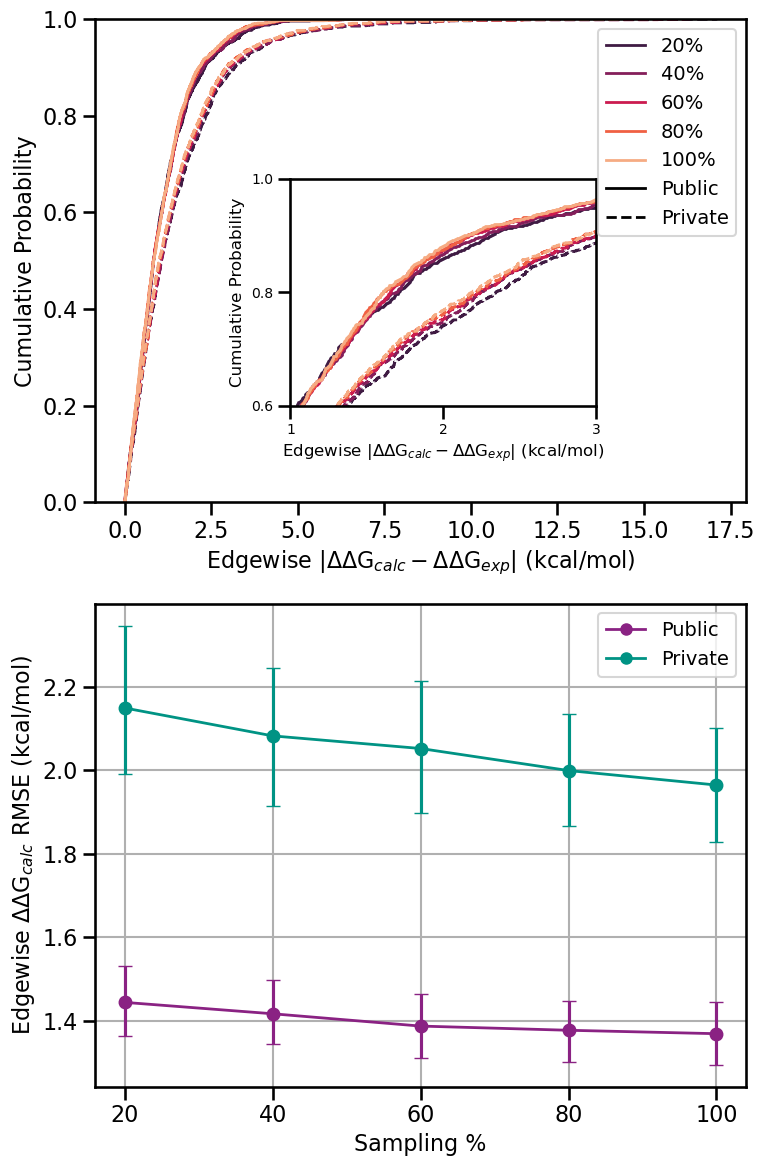

In [46]:
plot_edgewise_stats_per_ns(per_ns_ddgs_neutral, per_ns_ddgs_charged, per_ns_ddgs_neutral_private, per_ns_ddgs_charged_private, "edgewise_stats_per_ns.png")

In [47]:
# load all of the molecules so we can create mapping plots
import pathlib
from rdkit import Chem
all_ligands = {}
name_conversions = {
    "41 flip": "41-flip",
    "40 flip": "40-flip",
    "38 flip": "38-flip",
    "30 flip": "30-flip",
    "43 flip": "43-flip",
    "47 flip": "47-flip",
    "48 flip": "48-flip",
    "46 flip": "46-flip",
    "36 out": "36o",
    "37 out": "37o",
    "38 out": "38o",
    "39 out": "39o",
    "28 out": "28o",
    "CHEMBL3402756_2.7 redocked": "CHEMBL3402756_2.7_redocked",
    "CHEMBL3402757_6.5 redocked" : "CHEMBL3402757_6.5_redocked",
    "CHEMBL3402758_10 redocked": "CHEMBL3402758_10_redocked",
    "CHEMBL3402760_1 redocked":"CHEMBL3402760_1_redocked",
    "CHEMBL3402762_1 redocked": "CHEMBL3402762_1_redocked",
    "CHEMBL3402759_5.7 redocked": "CHEMBL3402759_5.7_redocked",
    "CHEMBL3402761_1 redocked": "CHEMBL3402761_1_redocked",
    "Example 22":"Example-22",
    "Example 23": "Example-23",
    "Example 14": "Example-14",
    "Example 9": "Example-9",
    "SHP099-1 Example 7": "SHP099-1-Example-7",
    "Example 28": "Example-28",
    "Example 24": "Example-24",
    "Example 26": "Example-26",
    "Example 6": "Example-6",
    "Example 1": "Example-1",
    "Example 30": "Example-30",
    "Example 8": "Example-8",
    "Example 29": "Example-29",
    "Example 2": "Example-2",
    "Example 25": "Example-25",
    "Example 4": "Example-4",
    "Example 3": "Example-3",
    "Example 27": "Example-27",
    "Example 5": "Example-5",
    "9 flip": "9-flip",
}
key_to_ligand = {}
base_data_folder = pathlib.Path("/Users/joshua/Documents/Software/IndustryBenchmarks2024/industry_benchmarks/input_structures/prepared_structures")
for folder in base_data_folder.glob("*"):
    if folder.is_dir() and folder != "template":
        for target_ligs in folder.glob("*/ligands.sdf"):
            # load the ligands
            supplier = Chem.SDMolSupplier(target_ligs, removeHs=False)
            for lig in supplier:
                name = lig.GetProp("_Name")
                if name in name_conversions:
                    name = name_conversions[name]
                all_ligands[(name, target_ligs.parent.name, folder.name)] = Chem.GetFormalCharge(lig)
                key_to_ligand[(name, target_ligs.parent.name, folder.name)] = lig

In [48]:
from gufe import SmallMoleculeComponent
import kartograf
from kartograf.filters import (
    filter_ringbreak_changes,
    filter_ringsize_changes,
    filter_whole_rings_only,
)
from rdkit.Chem import Draw
import io
import cairosvg
from PIL import Image
grid_x, grid_y = 2, 1
from gufe.visualization.mapping_visualization import draw_mapping

def mapping_karto(liga, ligb, target, system):
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(grid_x * 300, grid_y * 300, 300, 300)
    mapping_filters = [
            filter_ringbreak_changes,  # default
            filter_ringsize_changes,  # default
            filter_whole_rings_only,  # default
        ]
    mapper = kartograf.KartografAtomMapper(
        atom_map_hydrogens=True,
        additional_mapping_filter_functions=mapping_filters,
    )
    ligand_a = SmallMoleculeComponent(key_to_ligand[(liga, target, system)])
    ligand_b = SmallMoleculeComponent(key_to_ligand[(ligb, target, system)])
    mapping =  next(mapper.suggest_mappings(ligand_a, ligand_b))
    svg_text = draw_mapping(mapping._compA_to_compB, mapping.componentA.to_rdkit(), mapping.componentB.to_rdkit(), d2d)
    png_data = cairosvg.svg2png(bytestring=svg_text.encode('utf-8'))
    image = Image.open(io.BytesIO(png_data))
    return image


We now want to plot the top 3 and bottom 3 transformations ranked by the absolute error at 80% vs 100% sampling to show examples of slowly converging systems

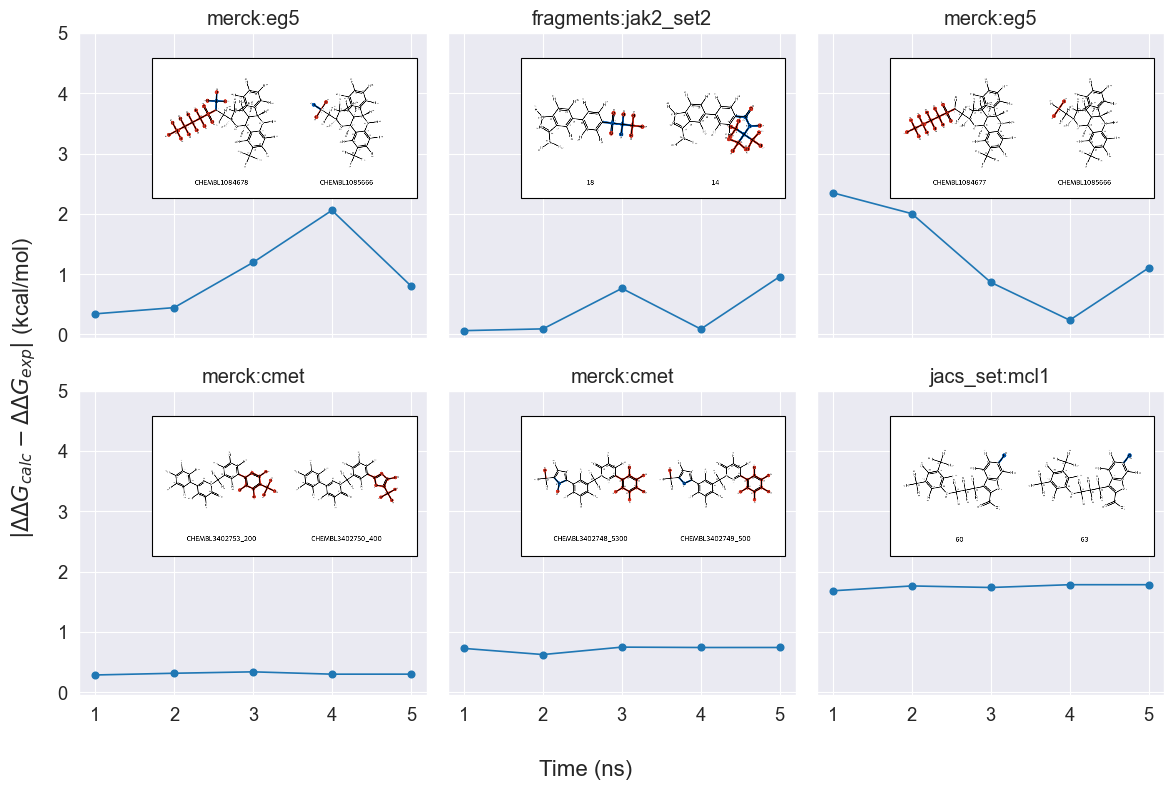

In [101]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("darkgrid")
    # for the neutral edges get the absolute difference between the 4 ns and 5 ns predictions for the public data
    neutral_df = pd.DataFrame(per_ns_ddgs_neutral)
    neutral_df = neutral_df[(neutral_df["Samples 5 ns DDG"].notna()) & (neutral_df["Samples 4 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
    # get the abs error at 4 ns vs 5 ns
    abs_error_4ns = abs(neutral_df["Samples 4 ns DDG"] - neutral_df["exp DDG (kcal/mol)"])
    abs_error_5ns = abs(neutral_df["Samples 5 ns DDG"] - neutral_df["exp DDG (kcal/mol)"])
    # get the abs difference between these two
    change_in_error = abs(abs_error_4ns - abs_error_5ns)
    # get the top 3 and bottom 3 edges by abs error after added the absolute difference to the dataframe
    neutral_df["abs_diff"] = change_in_error
    # sort the dataframe by the abs_diff column
    neutral_df = neutral_df.sort_values(by="abs_diff", ascending=False)
    # get the top 3 and bottom 3 edges
    top_3_edges = neutral_df.head(3)
    bottom_3_edges = neutral_df.tail(3)
    # combine the two dataframes
    selected_edges = pd.concat([top_3_edges, bottom_3_edges], ignore_index=True)
    # Step 3: Plotting setup
    n = 3
    fig, axs = plt.subplots(2, n, figsize=(4 * n, 8), sharey=True, sharex=True)
    axs = axs.flatten()
    for i, row in selected_edges.iterrows():
        ax = axs[i]
        diffs = []
        for j in range(1, 6):
            diffs.append(abs(row[f"Samples {j} ns DDG"] - row[f"exp DDG (kcal/mol)"]))

        ax.plot(np.arange(1, 6), diffs, marker='o')
        ax.set_title(f"{row['system group']}:{row['system name']}")

        img = mapping_karto(row["ligand_A"], row["ligand_B"], row["system name"], row["system group"])

        imagebox = OffsetImage(img, zoom=0.3)
        ab = AnnotationBbox(imagebox, (0.95, -0.01), frameon=True, xycoords='axes fraction',
                            box_alignment=(1, -1.2))
        ax.add_artist(ab)
    plt.ylim(top=5)
    fig.supxlabel('Time (ns)', fontsize=16)
    fig.supylabel(r"$|\Delta\Delta G_{calc} - \Delta\Delta G_{exp}|$ (kcal/mol)", fontsize=16)
    plt.tight_layout()
    plt.savefig("top_bottom_3_edges_neutral.png", dpi=300, bbox_inches="tight")
# plt.show()

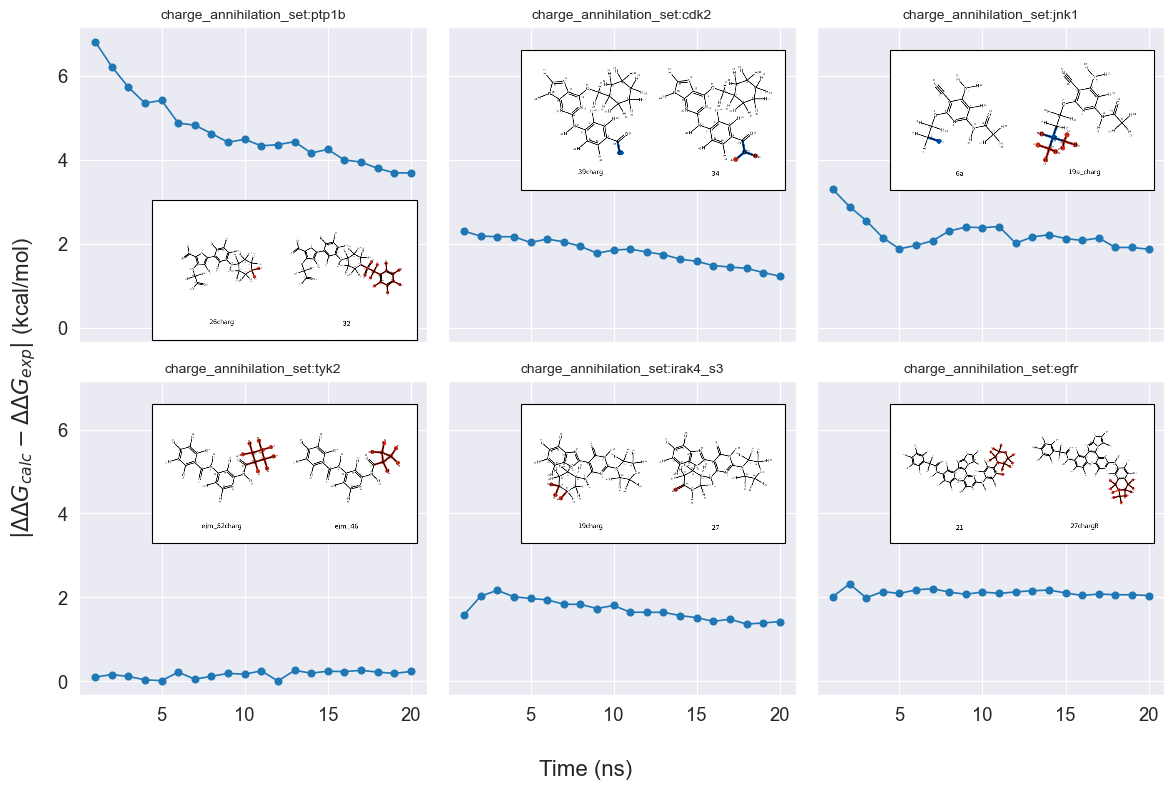

In [100]:
# same again for the charged edges
with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("darkgrid")
    charged_df = pd.DataFrame(per_ns_ddgs_charged)
    charged_df = charged_df[(charged_df["Samples 20 ns DDG"].notna()) & (charged_df["Samples 16 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
    # get the abs error
    abs_error_16 = abs(charged_df["Samples 16 ns DDG"] - charged_df["exp DDG (kcal/mol)"])
    abs_error_20 = abs(charged_df["Samples 20 ns DDG"] - charged_df["exp DDG (kcal/mol)"])
    # get the abs difference between these two
    abs_diff = abs(abs_error_16 - abs_error_20)
    # get the top 3 and bottom 3 edges by abs error after added the absolute difference to the dataframe
    charged_df["abs_diff"] = abs_diff
    # sort the dataframe by the abs_diff column
    charged_df = charged_df.sort_values(by="abs_diff", ascending=False)
    # get the top 3 and bottom 3 edges
    top_3_edges = charged_df.head(3)
    bottom_3_edges = charged_df.tail(3)
    # combine the two dataframes
    selected_edges = pd.concat([top_3_edges, bottom_3_edges], ignore_index=True)
    # Step 3: Plotting setup
    n = 3
    fig, axs = plt.subplots(2, n, figsize=(4 * n, 8), sharey=True, sharex=True)
    axs = axs.flatten()
    for j, row in selected_edges.iterrows():
        ax = axs[j]
        diffs = []
        for i in range(1, 21):
            diffs.append(abs(row[f"Samples {i} ns DDG"] - row[f"exp DDG (kcal/mol)"]))

        ax.plot(np.arange(1, 21), diffs, marker='o')
        ax.set_title(f"{row['system group']}:{row['system name']}", fontsize=10)
        img = mapping_karto(row["ligand_A"], row["ligand_B"], row["system name"], row["system group"])
        alignment = -1.3
        if j == 0:
            alignment = -0.1
        imagebox = OffsetImage(img, zoom=0.3)
        ab = AnnotationBbox(imagebox, (0.95, -0.01), frameon=True, xycoords='axes fraction',
                            box_alignment=(1, alignment))
        ax.add_artist(ab)

    fig.supxlabel('Time (ns)', fontsize=16)
    fig.supylabel(r"$|\Delta\Delta G_{calc} - \Delta\Delta G_{exp}|$ (kcal/mol)", fontsize=16)
    plt.tight_layout()
    plt.savefig("top_bottom_3_edges_charged.png", dpi=300, bbox_inches="tight")

In [79]:
# we need to make a new df combinging the charged and neutral edges and get the estimates per 20% of the total simulation time
combined_per_ns_data = []
for _, row in normal_edge_data.iterrows():
    if np.isnan(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "system group": row["system group"],
        "system name": row["system name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each 1/5 of total ns
    temp_cumulative_data = cumulative_data[(cumulative_data["system group"] == row["system group"]) & (cumulative_data["system name"] == row["system name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]
    fith_sample_time = int(total_ns / 5)

    for i in range(fith_sample_time, total_ns + 1, fith_sample_time):
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    combined_per_ns_data.append(cumulative_data_row)
combined_per_ns_df = pd.DataFrame(combined_per_ns_data)
combined_per_ns_df


,system group,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,charge_annihilation_set,cdk2,34,25,0.050000,0.0,0,0.860925,0.213371,0.907366,0.380215,0.691372,0.233876,0.653207,0.222241,0.456528,0.253792
1,charge_annihilation_set,cdk2,39charg,34,-1.510000,0.0,-1,-3.675394,0.191886,-3.447293,0.459189,-3.310455,0.341398,-2.987109,0.135790,-2.734255,0.244470
2,charge_annihilation_set,cdk2,39charg,25,-1.460000,0.0,-1,-2.935219,0.294969,-3.161536,0.448534,-2.843697,0.286023,-2.708498,0.298596,-2.866959,0.355077
3,charge_annihilation_set,dlk,17charg,8,-0.070001,0.0,0,0.170391,1.052105,0.041609,0.207820,-0.083986,0.214797,-0.043059,0.149009,0.091906,0.229812
4,charge_annihilation_set,dlk,4charg,8,-1.180000,0.0,0,-1.762323,0.060808,-1.664459,0.195709,-1.526440,0.177870,-1.564452,0.203490,-1.613313,0.121454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,merck,pfkfb3,49,47,-0.399159,0.0,0,0.754273,0.365762,0.835334,0.239717,0.916750,0.452002,0.856560,0.298544,0.817963,0.325819
1180,merck,pfkfb3,65,29,-0.158121,0.0,0,0.497839,0.608575,0.270352,0.424172,0.566655,0.153471,0.297737,0.158709,0.485801,0.245501
1181,merck,pfkfb3,29,64,0.223740,0.0,0,0.815219,0.514712,0.182572,0.454080,-0.097836,0.504744,-0.233379,0.180472,-0.323246,0.434290
1182,merck,pfkfb3,47,46,0.474092,0.0,0,-0.960734,0.275127,-0.830226,0.123748,-0.834919,0.101930,-0.743177,0.068187,-0.649200,0.090989


In [80]:
# same again for the private data
combined_per_ns_data_private = []
for _, row in private_edge_data.iterrows():
    if np.isnan(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "partner": row["partner_id"],
        "system name": row["dataset_name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each 1/5 of total ns
    temp_cumulative_data = private_cumulative_data[(private_cumulative_data["partner_id"] == row["partner_id"]) & (private_cumulative_data["dataset_name"] == row["dataset_name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]
    fith_sample_time = int(total_ns / 5)

    for i in range(fith_sample_time, total_ns + 1, fith_sample_time):
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    combined_per_ns_data_private.append(cumulative_data_row)
combined_per_ns_df_private = pd.DataFrame(combined_per_ns_data_private)
combined_per_ns_df_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,ASAP,Enterovirus,unknown_ligand_3,unknown_ligand_15,1.148118,0.055056,0,1.104402,0.136664,1.065402,0.113571,1.032865,0.083231,1.014247,0.088905,0.972771,0.080710
1,ASAP,Enterovirus,unknown_ligand_15,unknown_ligand_21,0.327255,0.076637,0,0.245326,0.278446,0.195591,0.249188,0.272850,0.135000,0.287770,0.054534,0.272273,0.138030
2,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_7,0.286348,0.032221,0,0.358455,0.296355,0.201361,0.166809,0.184357,0.209376,0.190192,0.125339,0.233306,0.140381
3,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_16,0.818136,0.048821,0,1.374171,0.281929,1.511584,0.360573,1.582223,0.327791,1.612850,0.166287,1.551585,0.149926
4,ASAP,Enterovirus,unknown_ligand_12,unknown_ligand_18,0.081814,0.094843,0,0.719973,0.259692,0.514005,0.145581,0.554642,0.141535,0.676114,0.143471,0.640925,0.105705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,Roche,target_D,ligand11,ligand12,2.561862,0.000000,0,2.183941,0.643764,2.646980,1.818435,2.770566,1.919833,2.565152,1.541890,2.049708,2.341527
1358,Roche,target_D,ligand0,ligand11,0.302856,0.000000,0,-2.440365,2.131070,-2.894143,1.298871,-2.691206,1.873933,-2.788925,1.604416,-1.950022,0.976101
1359,Roche,target_D,ligand8,ligand3,0.848769,0.000000,0,4.751131,3.875424,4.503254,3.178729,5.037318,2.624681,5.701962,2.505028,5.412539,3.130187
1360,Roche,target_D,ligand2,ligand3,1.876150,0.000000,0,2.367006,0.806749,2.181063,1.901754,2.414469,1.931305,3.915554,1.627744,4.712334,0.231165


In [129]:
def calculate_rmse_diff(df, time1, time2):
    sample_time1_ref = np.sqrt(np.mean((df[f"Samples {time1}% DDG"] - df["exp DDG (kcal/mol)"]) ** 2))
    sample_time2_ref = np.sqrt(np.mean((df[f"Samples {time2}% DDG"] - df["exp DDG (kcal/mol)"]) ** 2))
    rmse_diff = np.zeros(1000)
    for i in range(1000):
        sample = df.sample(frac=1, replace=True)
        sample_time1 = np.sqrt(np.mean((sample[f"Samples {time1}% DDG"] - sample["exp DDG (kcal/mol)"]) ** 2))
        sample_time2 = np.sqrt(np.mean((sample[f"Samples {time2}% DDG"] - sample["exp DDG (kcal/mol)"]) ** 2))
        rmse_diff[i] = sample_time1 - sample_time2
    ci_lower = np.percentile(rmse_diff, 2.5)
    ci_upper = np.percentile(rmse_diff, 97.5)
    print(f"RMSE at {time1}%: {sample_time1_ref:.2f}, RMSE at {time2}%: {sample_time2_ref:.2f}, Diff: {sample_time1_ref - sample_time2_ref:.2f}, 95% CI: [{ci_lower}, {ci_upper}]")

In [130]:
calculate_rmse_diff(combined_per_ns_df, 20, 100)

RMSE at 20%: 1.44, RMSE at 100%: 1.37, Diff: 0.07, 95% CI: [0.045333781108827076, 0.10251120061329222]


In [131]:
calculate_rmse_diff(combined_per_ns_df_private, 20, 100)

RMSE at 20%: 2.15, RMSE at 100%: 1.96, Diff: 0.18, 95% CI: [0.1235493307699539, 0.25625141305372445]


In [132]:
# check 80 vs 100
calculate_rmse_diff(combined_per_ns_df, 80, 100)
calculate_rmse_diff(combined_per_ns_df_private, 80, 100)

RMSE at 80%: 1.38, RMSE at 100%: 1.37, Diff: 0.01, 95% CI: [-0.002950575067644956, 0.016930824345133322]
RMSE at 80%: 2.00, RMSE at 100%: 1.96, Diff: 0.03, 95% CI: [0.016353025721517367, 0.0587928018146095]


Now we want to check the per-system edgewise DDG accuracy at 80 vs 100%.

In [140]:
combined_per_ns_df

,system group,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,charge_annihilation_set,cdk2,34,25,0.050000,0.0,0,0.860925,0.213371,0.907366,0.380215,0.691372,0.233876,0.653207,0.222241,0.456528,0.253792
1,charge_annihilation_set,cdk2,39charg,34,-1.510000,0.0,-1,-3.675394,0.191886,-3.447293,0.459189,-3.310455,0.341398,-2.987109,0.135790,-2.734255,0.244470
2,charge_annihilation_set,cdk2,39charg,25,-1.460000,0.0,-1,-2.935219,0.294969,-3.161536,0.448534,-2.843697,0.286023,-2.708498,0.298596,-2.866959,0.355077
3,charge_annihilation_set,dlk,17charg,8,-0.070001,0.0,0,0.170391,1.052105,0.041609,0.207820,-0.083986,0.214797,-0.043059,0.149009,0.091906,0.229812
4,charge_annihilation_set,dlk,4charg,8,-1.180000,0.0,0,-1.762323,0.060808,-1.664459,0.195709,-1.526440,0.177870,-1.564452,0.203490,-1.613313,0.121454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,merck,pfkfb3,49,47,-0.399159,0.0,0,0.754273,0.365762,0.835334,0.239717,0.916750,0.452002,0.856560,0.298544,0.817963,0.325819
1180,merck,pfkfb3,65,29,-0.158121,0.0,0,0.497839,0.608575,0.270352,0.424172,0.566655,0.153471,0.297737,0.158709,0.485801,0.245501
1181,merck,pfkfb3,29,64,0.223740,0.0,0,0.815219,0.514712,0.182572,0.454080,-0.097836,0.504744,-0.233379,0.180472,-0.323246,0.434290
1182,merck,pfkfb3,47,46,0.474092,0.0,0,-0.960734,0.275127,-0.830226,0.123748,-0.834919,0.101930,-0.743177,0.068187,-0.649200,0.090989


In [141]:
# make a new dataframe with the edgewise RMSE metrics per-system at 80% and 100% sampling
edgewise_rmse_data = []
import copy
nbootstrap = 1000
for system in combined_per_ns_df["system group"].unique():
    system_df = combined_per_ns_df[combined_per_ns_df["system group"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        print(f"Calculating RMSE for {system}:{target}")
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        # get the RMSE for 80% and 100% sampling
        
        rmse_80 = np.sqrt(np.mean((target_df["Samples 80% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        rmse_100 = np.sqrt(np.mean((target_df["Samples 100% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        # bootstrap the RMSE for 80% and 100% sampling
        rmse_80_bootstrap, rmse_100_bootstrap = np.zeros(nbootstrap), np.zeros(nbootstrap)
        for i in range(nbootstrap):
            sample_df = target_df.sample(frac=1, replace=True)
            rmse_80_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 80% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
            rmse_100_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 100% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
        # calculate the 95% CI for the RMSE
        ci_80_low = np.percentile(rmse_80_bootstrap, 2.5)
        ci_80_high = np.percentile(rmse_80_bootstrap, 97.5)
        ci_100_low = np.percentile(rmse_100_bootstrap, 2.5)
        ci_100_high = np.percentile(rmse_100_bootstrap, 97.5)
        edgewise_rmse_data.append({
            "system group": system,
            "system name": target,
            "RMSE 80%": rmse_80,
            "RMSE 100%": rmse_100,
            "RMSE 80% CI low": ci_80_low,
            "RMSE 80% CI high": ci_80_high,
            "RMSE 100% CI low": ci_100_low,
            "RMSE 100% CI high": ci_100_high,
            "N_edges": len(target_df),
        })
edgewise_rmse_df = pd.DataFrame(edgewise_rmse_data)
edgewise_rmse_df

Calculating RMSE for charge_annihilation_set:cdk2
Calculating RMSE for charge_annihilation_set:dlk
Calculating RMSE for charge_annihilation_set:egfr
Calculating RMSE for charge_annihilation_set:ephx2
Calculating RMSE for charge_annihilation_set:irak4_s2
Calculating RMSE for charge_annihilation_set:irak4_s3
Calculating RMSE for charge_annihilation_set:itk
Calculating RMSE for charge_annihilation_set:jak1
Calculating RMSE for charge_annihilation_set:jnk1
Calculating RMSE for charge_annihilation_set:ptp1b
Calculating RMSE for charge_annihilation_set:thrombin
Calculating RMSE for charge_annihilation_set:tyk2
Calculating RMSE for fragments:hsp90_2rings
Calculating RMSE for fragments:hsp90_single_ring
Calculating RMSE for fragments:jak2_set1
Calculating RMSE for fragments:jak2_set2
Calculating RMSE for fragments:liga
Calculating RMSE for fragments:mcl1
Calculating RMSE for fragments:mup1
Calculating RMSE for fragments:p38
Calculating RMSE for fragments:t4_lysozyme
Calculating RMSE for jacs_s

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,charge_annihilation_set,cdk2,1.169680,1.102058,0.873015,1.477109,0.780881,1.406959,3
1,charge_annihilation_set,dlk,0.920574,0.962016,0.344795,1.307553,0.390703,1.308223,6
2,charge_annihilation_set,egfr,2.004310,2.020741,1.248384,2.752707,1.325821,2.740498,7
3,charge_annihilation_set,ephx2,0.971273,0.894054,0.635054,1.140449,0.552554,1.137254,4
4,charge_annihilation_set,irak4_s2,1.332802,1.347623,0.899793,1.693102,0.901349,1.730844,7
5,charge_annihilation_set,irak4_s3,0.927441,0.925599,0.482702,1.281350,0.332447,1.265434,4
6,charge_annihilation_set,itk,1.298730,1.308476,0.745785,1.800556,0.804029,1.786948,5
7,charge_annihilation_set,jak1,1.319928,1.303528,0.795571,1.715553,0.715981,1.720984,7
8,charge_annihilation_set,jnk1,1.770678,1.609170,1.398555,2.077173,1.301287,1.866951,2
9,charge_annihilation_set,ptp1b,2.946179,2.886906,0.890300,3.995389,1.594128,3.684566,3


In [85]:
# add the weighted RMSE for the overall datasets
rmse_80, rmse_100 = np.zeros(nbootstrap), np.zeros(nbootstrap)
sample_rmse_80 = np.sqrt(np.sum(edgewise_rmse_df["RMSE 80%"] ** 2 * edgewise_rmse_df["N_edges"]) / np.sum(edgewise_rmse_df["N_edges"]))
sample_rmse_100 = np.sqrt(np.sum(edgewise_rmse_df["RMSE 100%"] ** 2 * edgewise_rmse_df["N_edges"]) / np.sum(edgewise_rmse_df["N_edges"]))
for i in range(nbootstrap):
    # bootstrap the data
    bootstrapped_data = edgewise_rmse_df.sample(n=len(edgewise_rmse_df), replace=True)
    rmse_80[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 80%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    rmse_100[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 100%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    

row_data = {
    "system name": "Weighted",
    "system group": "Overall",
    "RMSE 80%": sample_rmse_80,
    "RMSE 100%": sample_rmse_100,
    "RMSE 80% CI low": np.percentile(rmse_80, 2.5),
    "RMSE 80% CI high": np.percentile(rmse_80, 97.5),
    "RMSE 100% CI low": np.percentile(rmse_100, 2.5),
    "RMSE 100% CI high": np.percentile(rmse_100, 97.5),
    "N_edges": edgewise_rmse_df["N_edges"].sum(),
}
# add the row to the dataframe using concat
edgewise_rmse_df = pd.concat([edgewise_rmse_df, pd.DataFrame([row_data])], ignore_index=True)
edgewise_rmse_df

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,charge_annihilation_set,cdk2,1.169680,1.102058,0.603207,1.477109,0.406527,1.406959,3
1,charge_annihilation_set,dlk,0.920574,0.962016,0.344795,1.307489,0.398410,1.305389,6
2,charge_annihilation_set,egfr,2.004310,2.020741,1.257470,2.733353,1.339077,2.722878,7
3,charge_annihilation_set,ephx2,0.971273,0.894054,0.635054,1.140449,0.552554,1.137254,4
4,charge_annihilation_set,irak4_s2,1.332802,1.347623,0.889853,1.690967,0.862596,1.744785,7
5,charge_annihilation_set,irak4_s3,0.927441,0.925599,0.486180,1.281350,0.334878,1.265434,4
6,charge_annihilation_set,itk,1.298730,1.308476,0.745785,1.800556,0.804029,1.767439,5
7,charge_annihilation_set,jak1,1.319928,1.303528,0.795872,1.750454,0.723053,1.776387,7
8,charge_annihilation_set,jnk1,1.770678,1.609170,1.398555,2.077173,1.301287,1.866951,2
9,charge_annihilation_set,ptp1b,2.946179,2.886906,0.890300,3.995389,1.594128,3.684566,3


{'charge_annihilation_set': 11, 'fragments': 20, 'jacs_set': 28, 'janssen_bace': 32, 'mcs_docking_set': 34, 'merck': 42, 'miscellaneous_set': 47, 'scaffold_hopping_set': 49, 'water_set': 57, 'Overall': 59}


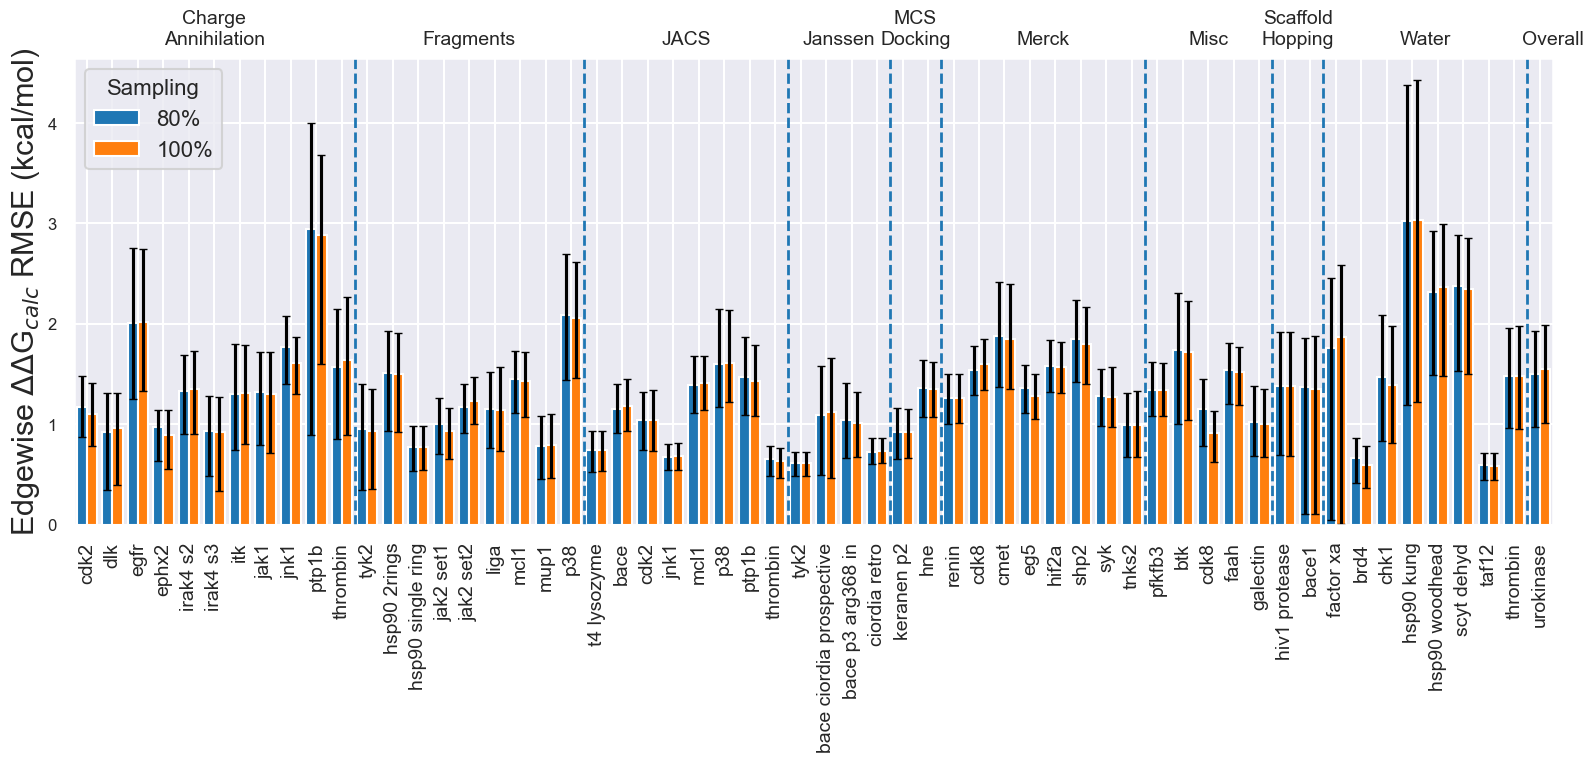

In [144]:
# plot the edgewise RMSE for 80% and 100% sampling
x = np.arange(len(edgewise_rmse_df))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.4

# Plot bars with error bars
rmse_err_80 = [edgewise_rmse_df['RMSE 80%'] - edgewise_rmse_df['RMSE 80% CI low'], edgewise_rmse_df['RMSE 80% CI high'] - edgewise_rmse_df['RMSE 80%']]
rmse_err_100 = [edgewise_rmse_df['RMSE 100%'] - edgewise_rmse_df['RMSE 100% CI low'], edgewise_rmse_df['RMSE 100% CI high'] - edgewise_rmse_df['RMSE 100%']]
# "OpenFE": "#009384", "FEP+": "#d9c4b1"
ax.bar(x - bar_width/2, edgewise_rmse_df['RMSE 80%'], yerr=rmse_err_80, width=bar_width, label='80%', capsize=3)
ax.bar(x + bar_width/2, edgewise_rmse_df['RMSE 100%'], yerr=rmse_err_100, width=bar_width, label='100%', capsize=3)

# Set labels and ticks
ax.set_xticks(x)
names = edgewise_rmse_df['system name'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=14)
ax.set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontsize=22)
# ax.set_title("Per-System RMSE and MUE with 95% Confidence Intervals")
ax.legend()

# Add colored background for classes
unique_classes = edgewise_rmse_df['system group'].unique()
# remove overall from the unique classes and add it to the end
unique_classes = [cls for cls in unique_classes if cls != "Overall"]
unique_classes.append("Overall")
class_bounds = edgewise_rmse_df.groupby('system group').size().cumsum().to_dict()
# move overall to the end
class_bounds["Overall"] = len(edgewise_rmse_df) + 1

for cls, bound in class_bounds.items():
    if cls == "Overall":
        continue
    class_bounds[cls] = bound - 1  # Adjust to match the last index of the class
print(class_bounds)
class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for the span but not the fill
    if cls != "charge_annihilation_set":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=14)
    class_start = end

plt.tight_layout()
plt.legend(title="Sampling", fontsize=16, title_fontsize=16)
plt.yticks(fontsize=12)
plt.xlim(-0.5, len(edgewise_rmse_df) - 0.5)
# plt.show()
plt.savefig("per_system_edgewise_rmse_sampling_public.png", dpi=300, bbox_inches='tight')

In [112]:
combined_per_ns_df_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,ASAP,Enterovirus,unknown_ligand_3,unknown_ligand_15,1.148118,0.055056,0,1.104402,0.136664,1.065402,0.113571,1.032865,0.083231,1.014247,0.088905,0.972771,0.080710
1,ASAP,Enterovirus,unknown_ligand_15,unknown_ligand_21,0.327255,0.076637,0,0.245326,0.278446,0.195591,0.249188,0.272850,0.135000,0.287770,0.054534,0.272273,0.138030
2,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_7,0.286348,0.032221,0,0.358455,0.296355,0.201361,0.166809,0.184357,0.209376,0.190192,0.125339,0.233306,0.140381
3,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_16,0.818136,0.048821,0,1.374171,0.281929,1.511584,0.360573,1.582223,0.327791,1.612850,0.166287,1.551585,0.149926
4,ASAP,Enterovirus,unknown_ligand_12,unknown_ligand_18,0.081814,0.094843,0,0.719973,0.259692,0.514005,0.145581,0.554642,0.141535,0.676114,0.143471,0.640925,0.105705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,Roche,target_D,ligand11,ligand12,2.561862,0.000000,0,2.183941,0.643764,2.646980,1.818435,2.770566,1.919833,2.565152,1.541890,2.049708,2.341527
1358,Roche,target_D,ligand0,ligand11,0.302856,0.000000,0,-2.440365,2.131070,-2.894143,1.298871,-2.691206,1.873933,-2.788925,1.604416,-1.950022,0.976101
1359,Roche,target_D,ligand8,ligand3,0.848769,0.000000,0,4.751131,3.875424,4.503254,3.178729,5.037318,2.624681,5.701962,2.505028,5.412539,3.130187
1360,Roche,target_D,ligand2,ligand3,1.876150,0.000000,0,2.367006,0.806749,2.181063,1.901754,2.414469,1.931305,3.915554,1.627744,4.712334,0.231165


In [147]:
# do the same again for the private data
edgewise_rmse_data_private = []
import copy
nbootstrap = 1000
for system in combined_per_ns_df_private["partner"].unique():
    system_df = combined_per_ns_df_private[combined_per_ns_df_private["partner"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        print(f"Calculating RMSE for {system}:{target}")
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        # get the RMSE for 80% and 100% sampling
        
        rmse_80 = np.sqrt(np.mean((target_df["Samples 80% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        rmse_100 = np.sqrt(np.mean((target_df["Samples 100% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        # bootstrap the RMSE for 80% and 100% sampling
        rmse_80_bootstrap, rmse_100_bootstrap = np.zeros(nbootstrap), np.zeros(nbootstrap)
        for i in range(nbootstrap):
            sample_df = target_df.sample(frac=1, replace=True)
            rmse_80_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 80% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
            rmse_100_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 100% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
        # calculate the 95% CI for the RMSE
        ci_80_low = np.percentile(rmse_80_bootstrap, 2.5)
        ci_80_high = np.percentile(rmse_80_bootstrap, 97.5)
        ci_100_low = np.percentile(rmse_100_bootstrap, 2.5)
        ci_100_high = np.percentile(rmse_100_bootstrap, 97.5)
        edgewise_rmse_data_private.append({
            "system group": system,
            "system name": target,
            "RMSE 80%": rmse_80,
            "RMSE 100%": rmse_100,
            "RMSE 80% CI low": ci_80_low,
            "RMSE 80% CI high": ci_80_high,
            "RMSE 100% CI low": ci_100_low,
            "RMSE 100% CI high": ci_100_high,
            "N_edges": len(target_df),
        })
edgewise_rmse_df_private = pd.DataFrame(edgewise_rmse_data_private)
edgewise_rmse_df_private

Calculating RMSE for ASAP:Enterovirus
Calculating RMSE for ASAP:MERS
Calculating RMSE for ASAP:SARS2-Mpro
Calculating RMSE for AbbVie:AbbVie_private_A
Calculating RMSE for AbbVie:AbbVie_private_B
Calculating RMSE for BI:systemB
Calculating RMSE for BI:systemC
Calculating RMSE for BI:systemD
Calculating RMSE for BI:systemE
Calculating RMSE for BI:systemF
Calculating RMSE for BI:systemG
Calculating RMSE for BI:systemH
Calculating RMSE for BI:systemI
Calculating RMSE for BI:systemK
Calculating RMSE for EliLilly:Project0
Calculating RMSE for EliLilly:Project1
Calculating RMSE for EliLilly:Project2
Calculating RMSE for GSK:GSK_PRIVATE_1
Calculating RMSE for GSK:GSK_PRIVATE_2
Calculating RMSE for Genentech:GNE_Private
Calculating RMSE for Janssen:systemA_set1
Calculating RMSE for Janssen:systemA_set2
Calculating RMSE for Janssen:systemB_set1
Calculating RMSE for Janssen:systemC_set1
Calculating RMSE for Janssen:systemD_set1
Calculating RMSE for Merck:merck_private_G
Calculating RMSE for Merc

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,ASAP,Enterovirus,0.465237,0.422656,0.268641,0.608211,0.259173,0.552640,14
1,ASAP,MERS,1.189177,1.134112,0.802920,1.566497,0.739692,1.509477,20
2,ASAP,SARS2-Mpro,0.862250,0.874368,0.668117,1.052517,0.684964,1.055801,44
3,AbbVie,AbbVie_private_A,1.873495,1.863700,1.129104,2.637924,1.126233,2.643301,26
4,AbbVie,AbbVie_private_B,1.412407,1.418850,1.112797,1.723637,1.114017,1.739982,29
5,BI,systemB,1.964319,1.947296,1.501871,2.414594,1.455616,2.406447,17
6,BI,systemC,2.291301,2.264186,1.760970,2.764072,1.749053,2.703637,18
7,BI,systemD,1.052465,1.055158,0.818549,1.261323,0.825171,1.260870,39
8,BI,systemE,2.982341,3.074102,1.891197,3.845388,1.973658,3.956832,15
9,BI,systemF,1.320924,1.337760,0.777608,1.816688,0.775680,1.845509,16


In [148]:
# add the weighted RMSE for the overall datasets
rmse_80, rmse_100 = np.zeros(nbootstrap), np.zeros(nbootstrap)
for i in range(nbootstrap):
    # bootstrap the data
    bootstrapped_data = edgewise_rmse_df_private.sample(n=len(edgewise_rmse_df_private), replace=True)
    rmse_80[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 80%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    rmse_100[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 100%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    

row_data = {
    "system name": "Weighted\nRMSE",
    "system group": "Overall",
    "RMSE 80%": np.mean(rmse_80),
    "RMSE 100%": np.mean(rmse_100),
    "RMSE 80% CI low": np.percentile(rmse_80, 2.5),
    "RMSE 80% CI high": np.percentile(rmse_80, 97.5),
    "RMSE 100% CI low": np.percentile(rmse_100, 2.5),
    "RMSE 100% CI high": np.percentile(rmse_100, 97.5),
    "N_edges": edgewise_rmse_df_private["N_edges"].sum(),
}
# add the row to the dataframe using concat
edgewise_rmse_df_private = pd.concat([edgewise_rmse_df_private, pd.DataFrame([row_data])], ignore_index=True)
edgewise_rmse_df_private

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,ASAP,Enterovirus,0.465237,0.422656,0.268641,0.608211,0.259173,0.552640,14
1,ASAP,MERS,1.189177,1.134112,0.802920,1.566497,0.739692,1.509477,20
2,ASAP,SARS2-Mpro,0.862250,0.874368,0.668117,1.052517,0.684964,1.055801,44
3,AbbVie,AbbVie_private_A,1.873495,1.863700,1.129104,2.637924,1.126233,2.643301,26
4,AbbVie,AbbVie_private_B,1.412407,1.418850,1.112797,1.723637,1.114017,1.739982,29
5,BI,systemB,1.964319,1.947296,1.501871,2.414594,1.455616,2.406447,17
6,BI,systemC,2.291301,2.264186,1.760970,2.764072,1.749053,2.703637,18
7,BI,systemD,1.052465,1.055158,0.818549,1.261323,0.825171,1.260870,39
8,BI,systemE,2.982341,3.074102,1.891197,3.845388,1.973658,3.956832,15
9,BI,systemF,1.320924,1.337760,0.777608,1.816688,0.775680,1.845509,16


{'ASAP': 3, 'AbbVie': 5, 'BI': 14, 'EliLilly': 17, 'GSK': 19, 'Genentech': 20, 'Janssen': 25, 'Merck': 27, 'Odyssey': 28, 'Overall': 39, 'Roche': 37}


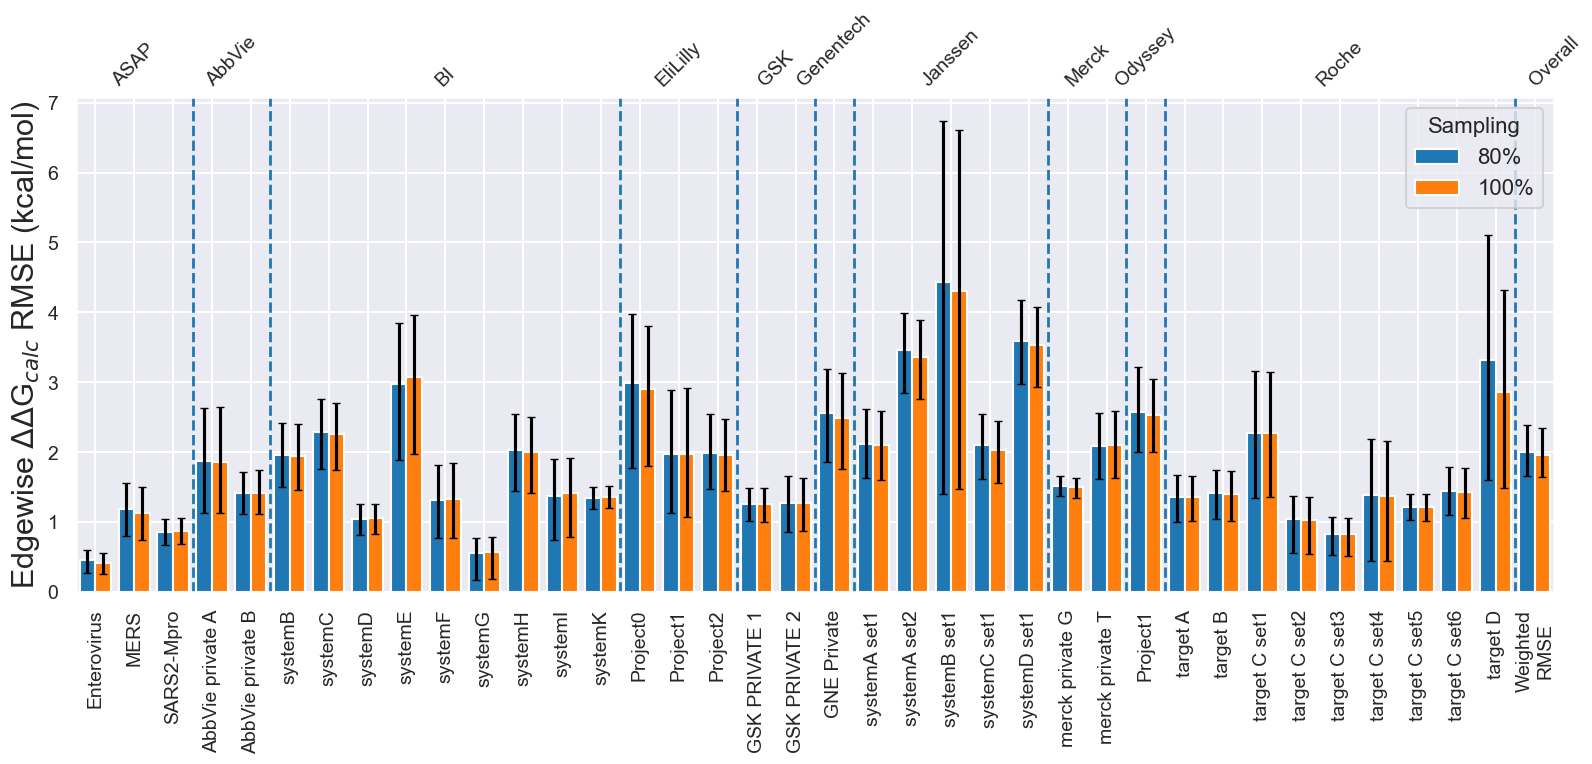

In [151]:
# plot the edgewise RMSE for 80% and 100% sampling
x = np.arange(len(edgewise_rmse_df_private))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.4

# Plot bars with error bars
rmse_err_80 = [edgewise_rmse_df_private['RMSE 80%'] - edgewise_rmse_df_private['RMSE 80% CI low'], edgewise_rmse_df_private['RMSE 80% CI high'] - edgewise_rmse_df_private['RMSE 80%']]
rmse_err_100 = [edgewise_rmse_df_private['RMSE 100%'] - edgewise_rmse_df_private['RMSE 100% CI low'], edgewise_rmse_df_private['RMSE 100% CI high'] - edgewise_rmse_df_private['RMSE 100%']]
# "OpenFE": "#009384", "FEP+": "#d9c4b1"
ax.bar(x - bar_width/2, edgewise_rmse_df_private['RMSE 80%'], yerr=rmse_err_80, width=bar_width, label='80%', capsize=3)
ax.bar(x + bar_width/2, edgewise_rmse_df_private['RMSE 100%'], yerr=rmse_err_100, width=bar_width, label='100%', capsize=3)

# Set labels and ticks
ax.set_xticks(x)
names = edgewise_rmse_df_private['system name'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=14)
ax.set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontsize=22)
# ax.set_title("Per-System RMSE and MUE with 95% Confidence Intervals")
ax.legend()

# Add colored background for classes
unique_classes = edgewise_rmse_df_private['system group'].unique()
# remove overall from the unique classes and add it to the end
unique_classes = [cls for cls in unique_classes if cls != "Overall"]
unique_classes.append("Overall")
class_bounds = edgewise_rmse_df_private.groupby('system group').size().cumsum().to_dict()
# # move overall to the end
class_bounds["Overall"] = len(edgewise_rmse_df_private) + 1

# change the roche end limit
class_bounds["Roche"] -= 1 # Adjust to match the last index of the class
print(class_bounds)
class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for the span but not the fill
    if cls != "ASAP":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=14, rotation=45)
    class_start = end

plt.tight_layout()
plt.legend(title="Sampling", fontsize=16, title_fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(-0.5, len(edgewise_rmse_df_private) - 0.5)
# plt.show()
plt.savefig("per_system_edgewise_rmse_sampling_private.png", dpi=300, bbox_inches='tight')